In [1]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')


In [2]:
#!pip install sktime
#!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

import pmdarima

from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.inspection import permutation_importance

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import SlidingWindowSplitter

import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

%matplotlib inline
pd.options.mode.chained_assignment= None

# References:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

### Loading Data

In [3]:
df_train_features = pd.read_csv('data/dengue_features_train.csv')
df_test_features = pd.read_csv('data/dengue_features_test.csv')
df_train_labels = pd.read_csv('data/dengue_labels_train.csv')

### Seperating data for SJ and IQ

In [4]:
df_train_features_sj = df_train_features.loc[df_train_features['city']=='sj',:].reset_index()
df_train_labels_sj = df_train_labels.loc[df_train_labels['city']=='sj',:].reset_index()
df_test_features_sj = df_test_features.loc[df_test_features['city']=='sj',:].reset_index()
print('San Juan:')
print('Total number of examples: ',df_train_features_sj.shape[0])
print('Total number of dengues cases: ',df_train_labels_sj['total_cases'].sum())
print('Total number of dengues cases per week on average: ',math.ceil(df_train_labels_sj['total_cases'].sum()/df_train_labels_sj.shape[0]))
print('Per year counts:\n')
display(pd.DataFrame([df_train_features_sj.rename(columns={'year':'no_of_weeks'})['no_of_weeks'].value_counts().sort_index(),df_train_labels_sj.groupby('year')['total_cases'].sum().sort_index()]))

print('Iquitos:')
df_train_features_iq = df_train_features.loc[df_train_features['city']=='iq',:].reset_index()
df_train_labels_iq = df_train_labels.loc[df_train_labels['city']=='iq',:].reset_index()
df_test_features_iq = df_test_features.loc[df_test_features['city']=='iq',:].reset_index()
print('\nTotal number of examples: ', df_train_features_iq.shape[0])
print('Total number of dengues cases: ',df_train_labels_iq['total_cases'].sum())
print('Total number of dengues cases per week on average: ',math.ceil(df_train_labels_iq['total_cases'].sum()/df_train_labels_iq.shape[0]))
print('Per year counts:\n')
display(pd.DataFrame([df_train_features_iq.rename(columns={'year':'no_of_weeks'})['no_of_weeks'].value_counts().sort_index(),df_train_labels_iq.groupby('year')['total_cases'].sum().sort_index()]))

San Juan:
Total number of examples:  936
Total number of dengues cases:  31993
Total number of dengues cases per week on average:  35
Per year counts:



,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
no_of_weeks,35,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,17
total_cases,866,2801,2371,1156,6533,1333,855,1454,4595,1633,492,1463,452,949,610,1805,550,1969,106


Iquitos:

Total number of examples:  520
Total number of dengues cases:  3934
Total number of dengues cases per week on average:  8
Per year counts:



,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
no_of_weeks,26,52,52,52,52,52,52,52,52,52,26
total_cases,4,14,704,114,638,311,436,365,801,324,223


### Distribution of dengue cases

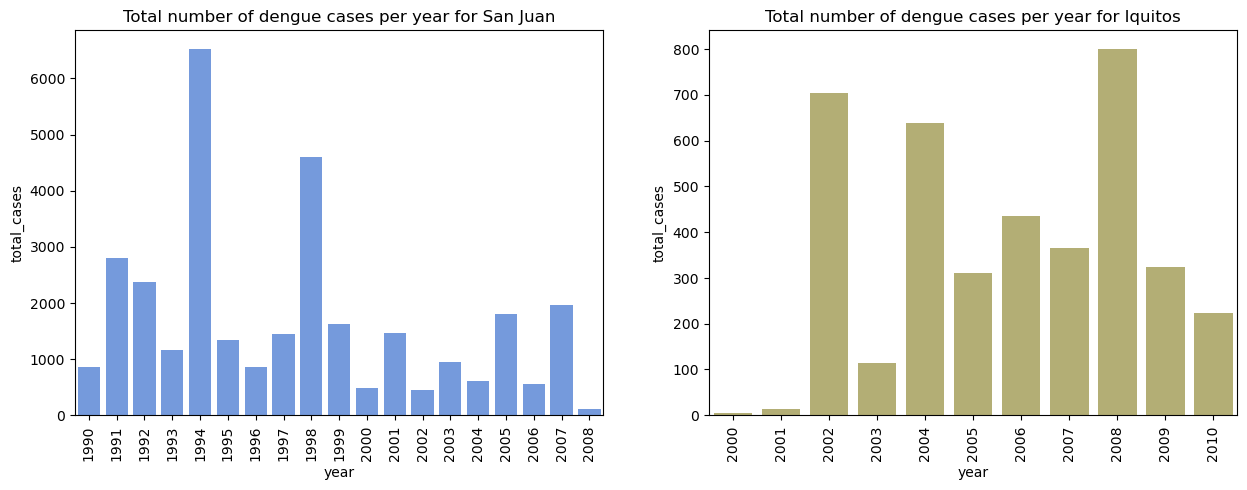

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
g1 = sns.barplot(data=df_train_labels_sj.groupby(['year'])['total_cases'].sum().reset_index(), x='year',y='total_cases',color = 'cornflowerblue',ax=axs[0])
g1.set_xticklabels(g1.get_xticklabels(),rotation=90);
g1.set_title('Total number of dengue cases per year for San Juan');
g2 = sns.barplot(data=df_train_labels_iq.groupby(['year'])['total_cases'].sum().reset_index(), x='year',y='total_cases',color = 'darkkhaki',ax=axs[1])
axs[1].set_title('Total number of dengue cases per year for Iquitos')
g2.set_xticklabels(g2.get_xticklabels(),rotation=90);

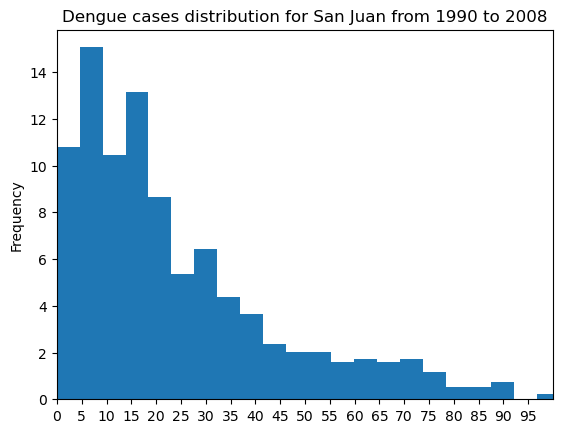

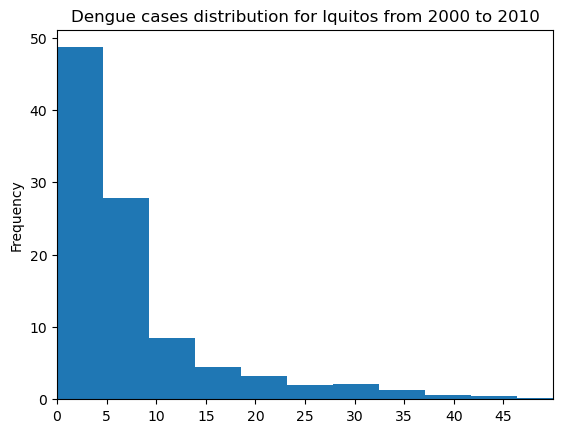

In [6]:
df = df_train_labels.loc[df_train_labels['city']=='sj','total_cases']
df.plot.hist(weights=100*np.ones_like(df)/len(df),bins=100)
plt.xlim((0,100))
plt.xticks(range(0,100,5));
plt.title('Dengue cases distribution for San Juan from 1990 to 2008');

plt.figure()
df = df_train_labels.loc[df_train_labels['city']=='iq','total_cases']
df.plot.hist(weights=100*np.ones_like(df)/len(df),bins=25)
plt.xlim((0,50))
plt.xticks(range(0,50,5));
plt.title('Dengue cases distribution for Iquitos from 2000 to 2010');

### Feature understanding

In [7]:
df_train_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [8]:
print('Number of total columns:',len(df_train_features.columns),'\n')
print(list(df_train_features.columns),'\n')
print('Number of useable features:', len(df_train_features.drop(['city', 'year', 'weekofyear', 'week_start_date'],axis=1).columns),'\n')
print('Info for iq = Iquitos and sj = San Juan:')
display(pd.DataFrame({
    'no. of observations (train)': df_train_features.groupby('city').size(),
    'from (train)': df_train_features.groupby('city')['year'].min(),
    'to (train)': df_train_features.groupby('city')['year'].max(),
    'no. of years (train)':df_train_features.groupby('city')['year'].nunique(),
    'no. of observations (test)': df_test_features.groupby('city').size(),
    'from (test)': df_test_features.groupby('city')['year'].min(),
    'to (test)': df_test_features.groupby('city')['year'].max(),
    'no. of years (test)':df_test_features.groupby('city')['year'].nunique(),
    'no. of dengues cases':df_train_labels.groupby('city')['total_cases'].sum(),
    'avg no. of dengues cases per week':df_train_labels.groupby('city')['total_cases'].mean()}))

Number of total columns: 24 

['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm'] 

Number of useable features: 20 

Info for iq = Iquitos and sj = San Juan:


,no. of observations (train),from (train),to (train),no. of years (train),no. of observations (test),from (test),to (test),no. of years (test),no. of dengues cases,avg no. of dengues cases per week
city,,,,,,,,,,
iq,520,2000,2010,11,156,2010,2013,4,3934,7.565385
sj,936,1990,2008,19,260,2008,2013,6,31993,34.180556


In [9]:
useable_features = list(df_train_features.drop(['city','weekofyear','week_start_date','year'],axis=1).columns)

### Feature Description

In [10]:
ndvi = [x for x in list(df_train_features.columns) if 'ndvi' in x] 
reanalysis = [x for x in list(df_train_features.columns) if 'reanalysis' in x]
precip = [x for x in list(df_train_features.columns) if 'precipitation' in x]
station = [x for x in list(df_train_features.columns) if 'station' in x]
all_features = [ndvi,reanalysis,precip,station]
max_len = max([len(i) for i in all_features])
for i in range(len(all_features)):
    if len(all_features) < max_len:
        all_features[i] += [''] * (max_len - len(all_features[i]))

display(pd.DataFrame({
    'CDR Normalized Difference Vegetation Index':all_features[0],
    'NCEP Climate Forecast System Reanalysis':all_features[1],
    'CDR PERSIANN Precipitation Product':all_features[2],
    'GHCN daily climate data':all_features[3]}))

,CDR Normalized Difference Vegetation Index,NCEP Climate Forecast System Reanalysis,CDR PERSIANN Precipitation Product,GHCN daily climate data
0,ndvi_ne,reanalysis_air_temp_k,precipitation_amt_mm,station_avg_temp_c
1,ndvi_nw,reanalysis_avg_temp_k,,station_diur_temp_rng_c
2,ndvi_se,reanalysis_dew_point_temp_k,,station_max_temp_c
3,ndvi_sw,reanalysis_max_air_temp_k,,station_min_temp_c
4,,reanalysis_min_air_temp_k,,station_precip_mm
5,,reanalysis_precip_amt_kg_per_m2,,
6,,reanalysis_relative_humidity_percent,,
7,,reanalysis_sat_precip_amt_mm,,
8,,reanalysis_specific_humidity_g_per_kg,,
9,,reanalysis_tdtr_k,,


### Distribution of Features

#### Vegetation

In [11]:
def plot_distributions(ls,w,h,ft,r,c,feature,sharey=False):
    l = [x for x in ls if x != '']
    fig,axs = plt.subplots(nrows=r, ncols=c,figsize=(w,h),sharey=sharey)
    if hasattr(axs, "__len__"):
        axs = axs.flatten()
        for i,a in zip(l,axs):
            sns.boxplot(data=df_train_features, y=i, x="city",ax=a)
    else:
        for i in l:
            sns.boxplot(data=df_train_features, y=i, x="city",ax=axs)
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle('Distribution of '+ feature +' features for both San Juan and Iquitos', fontsize = ft)

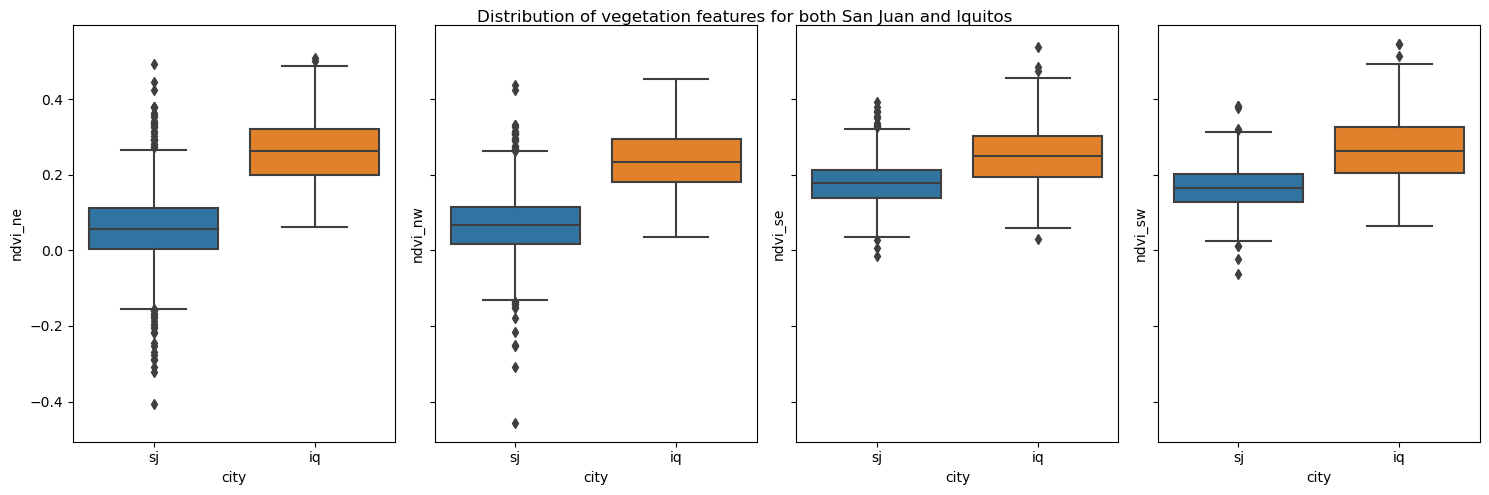

In [12]:
plot_distributions(ndvi,15,5,12,1,4,'vegetation',True)

There seems to be more vegetation in Iquitos compared to San Juan. Iquitos also seems to have fewer water bodies (cases where ndvi < 0). There are outlier areas in ndvi where there is more vegetation. 

In [13]:
sj_correlations = pd.concat([df_train_features_sj.loc[:,useable_features],df_train_labels_sj.loc[:,'total_cases']],axis=1).corr()
iq_correlations = pd.concat([df_train_features_iq.loc[:,useable_features],df_train_labels_iq.loc[:,'total_cases']],axis=1).corr()

In [14]:
def corr_heatmap(var,var_list,w=25,h=10):
    fig, axs = plt.subplots(1,2, figsize=(w,h))
    for i,j,k in zip(range(2),[sj_correlations,iq_correlations],['San Juan','Iquitos']):
        sns.heatmap(j.reset_index().loc[(j.reset_index()['index'].str.contains(var)|j.reset_index()['index'].str.contains("total_cases")),
                                                  [x for x in var_list if x != '']+['index']+['total_cases']].set_index('index'),
               cmap="crest",annot=True,ax=axs[i]);
    
        axs[i].title.set_text(k);
    fig.tight_layout()
    sns.set(style="whitegrid", font_scale=2.5)


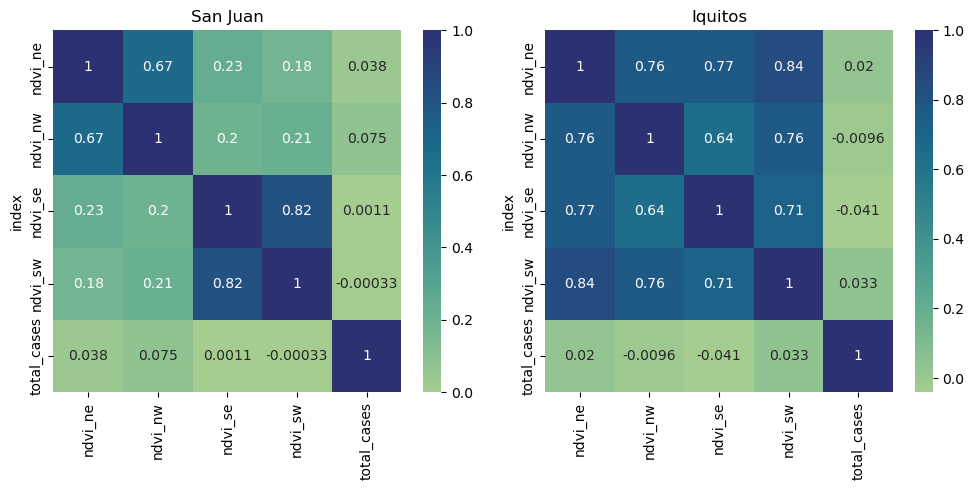

In [15]:
corr_heatmap('ndvi',ndvi,10,5)
matplotlib.rc_file_defaults()

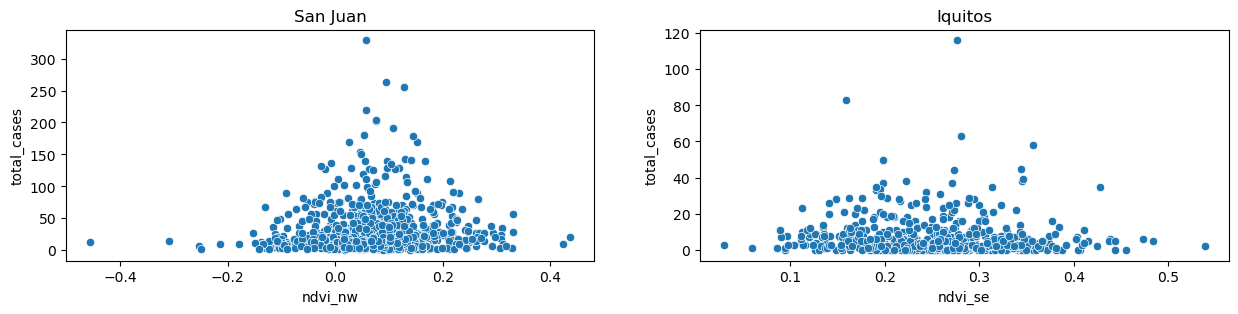

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
sns.scatterplot(x="ndvi_nw", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="ndvi_se", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Reanalysis 

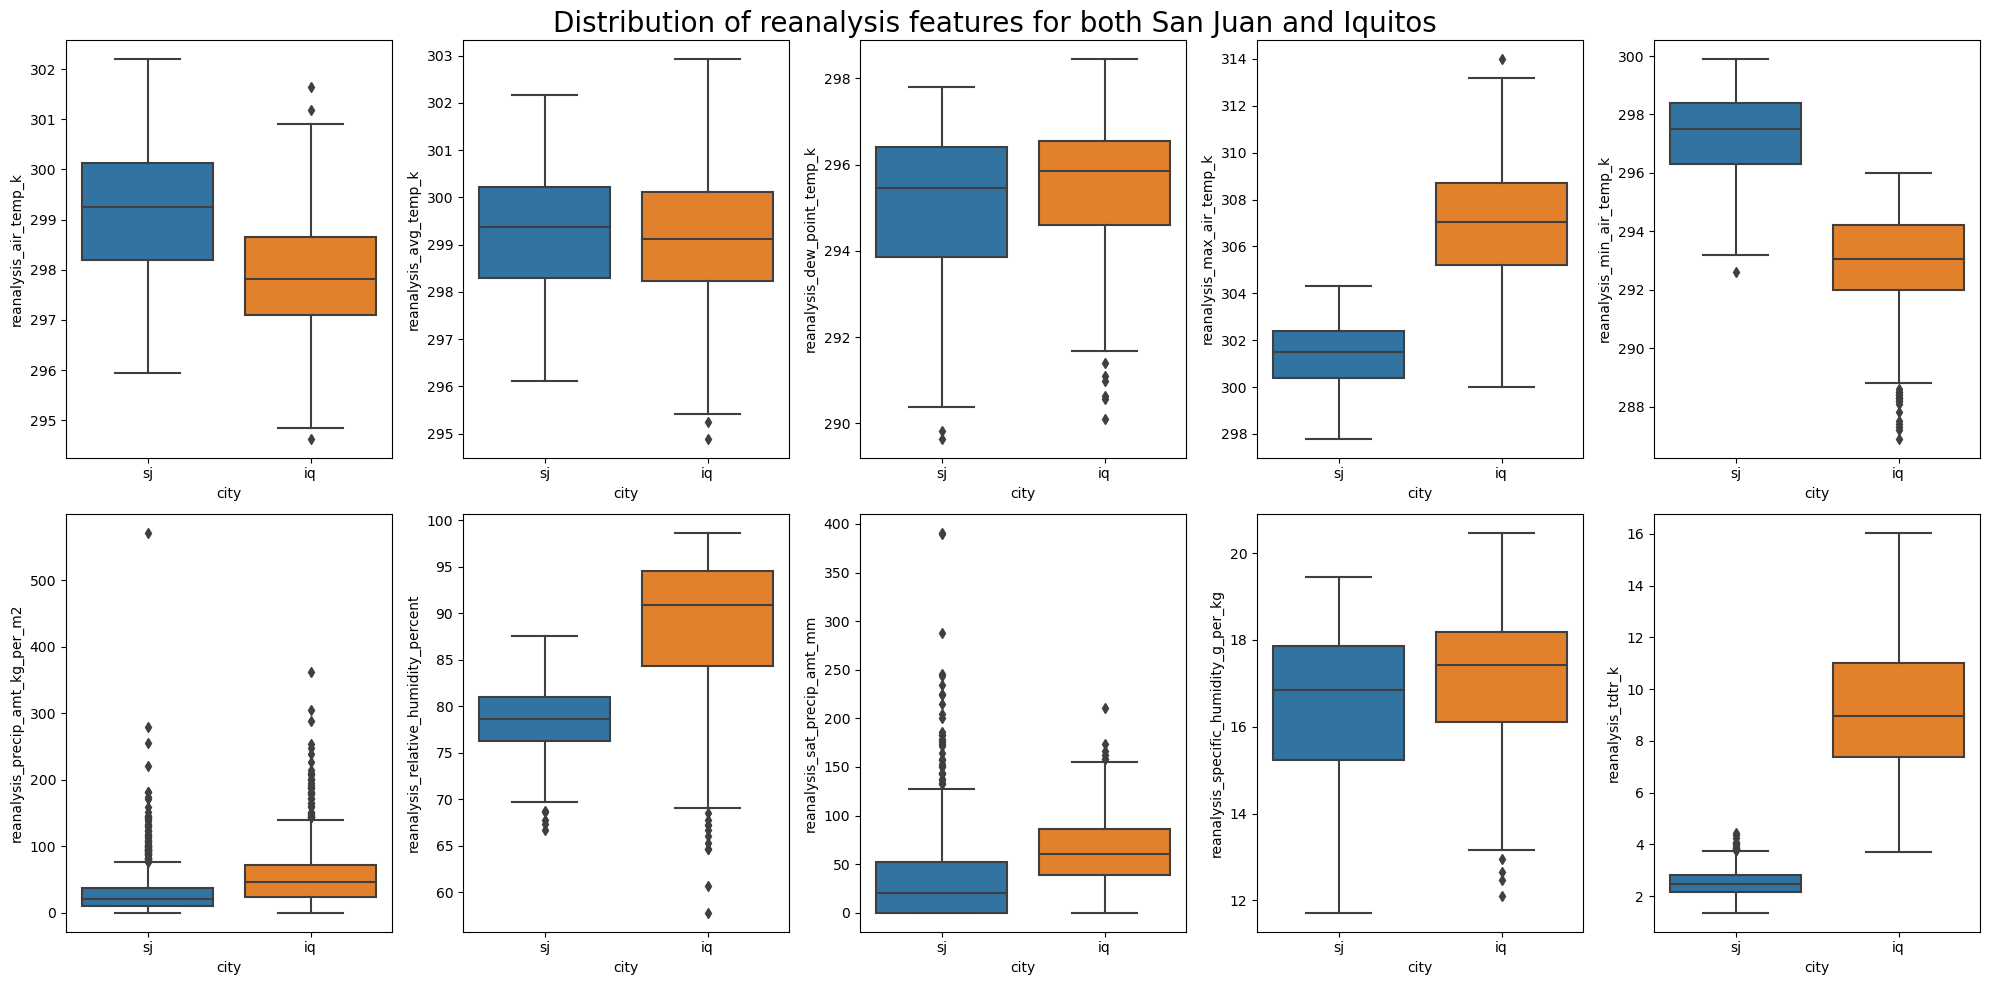

In [17]:
plot_distributions(reanalysis,20,10,20,2,5,'reanalysis')

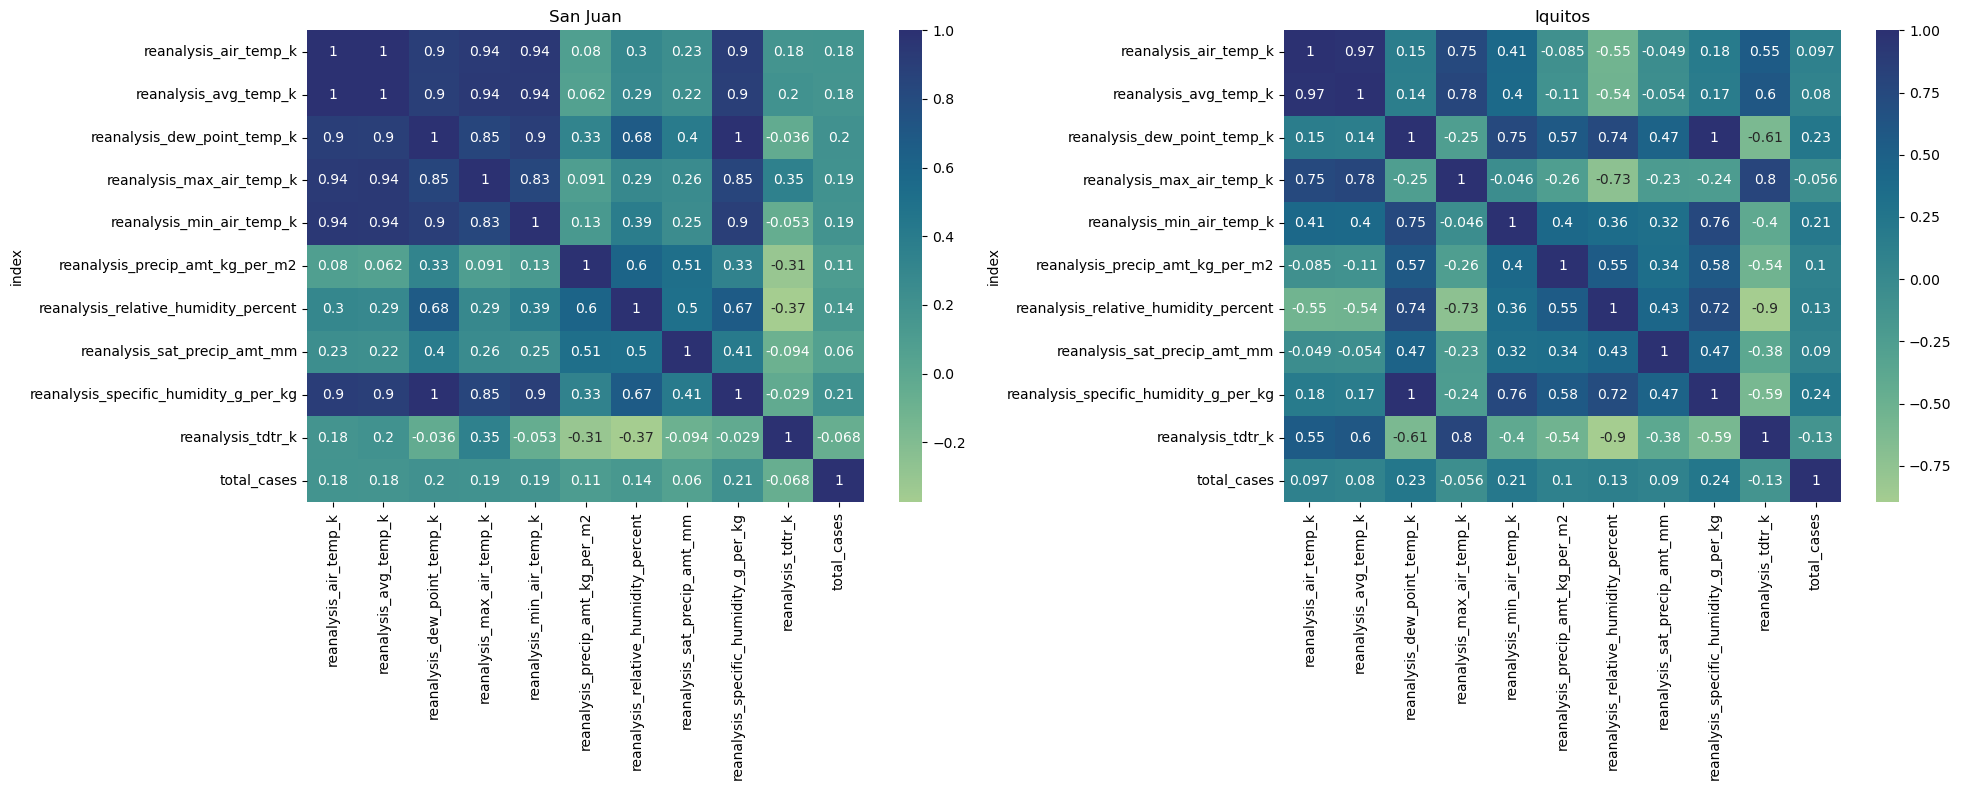

In [18]:
var = 'reanalysis'
var_list = reanalysis
corr_heatmap('reanalysis',reanalysis,20,8)
matplotlib.rc_file_defaults()

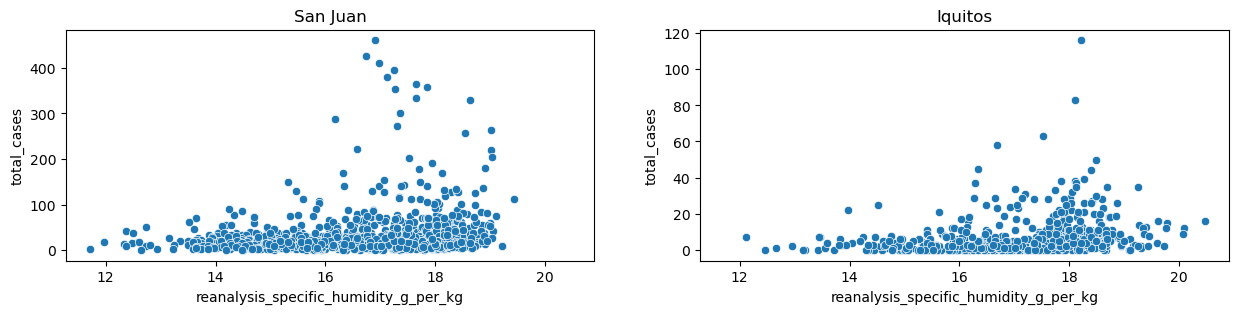

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Precipitation

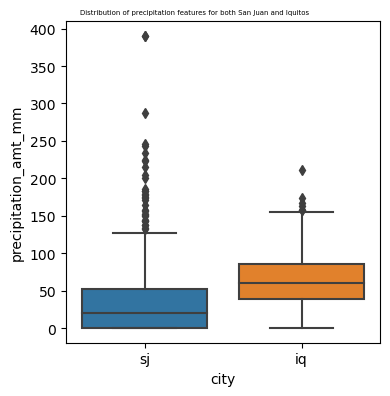

In [20]:
plot_distributions(precip,4,4,5,1,1,'precipitation')

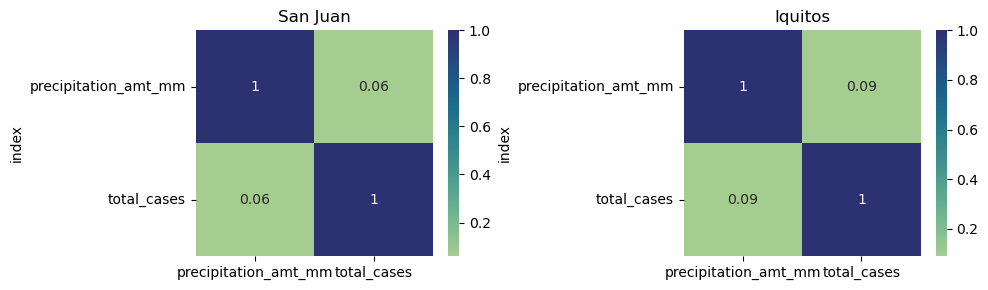

In [21]:
corr_heatmap('precipitation',precip,10,3)
matplotlib.rc_file_defaults()

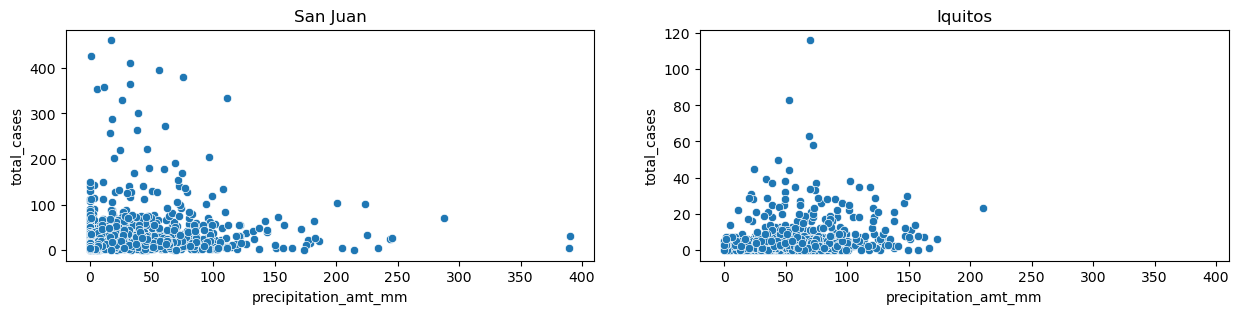

In [22]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="precipitation_amt_mm", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="precipitation_amt_mm", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Climate

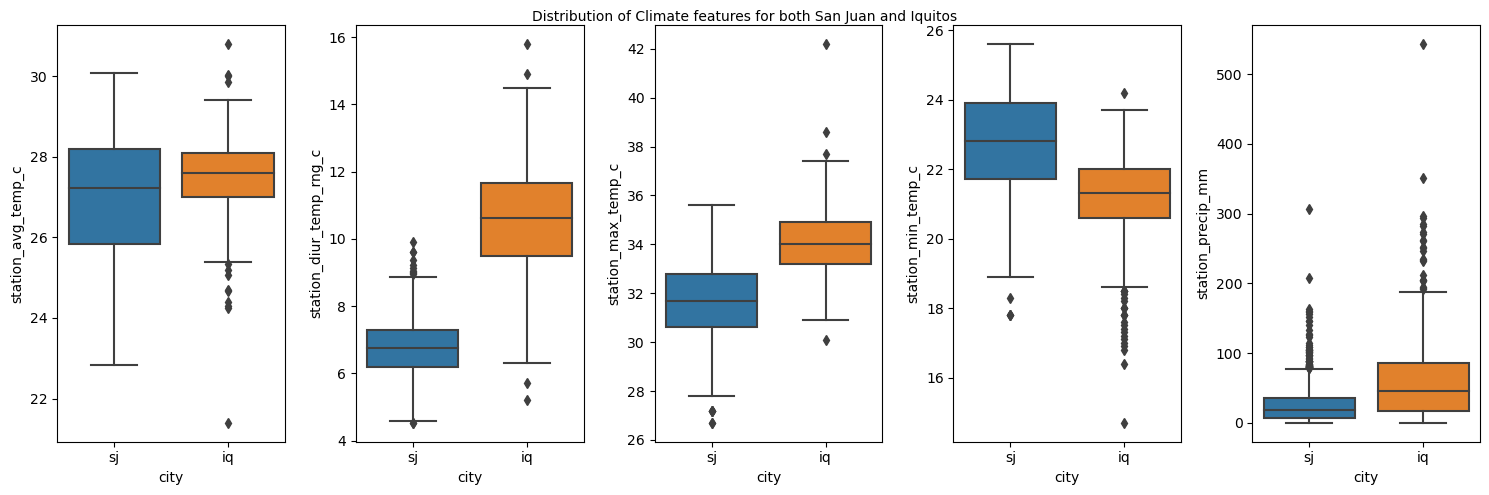

In [23]:
plot_distributions(station,15,5,10,1,5,'Climate')

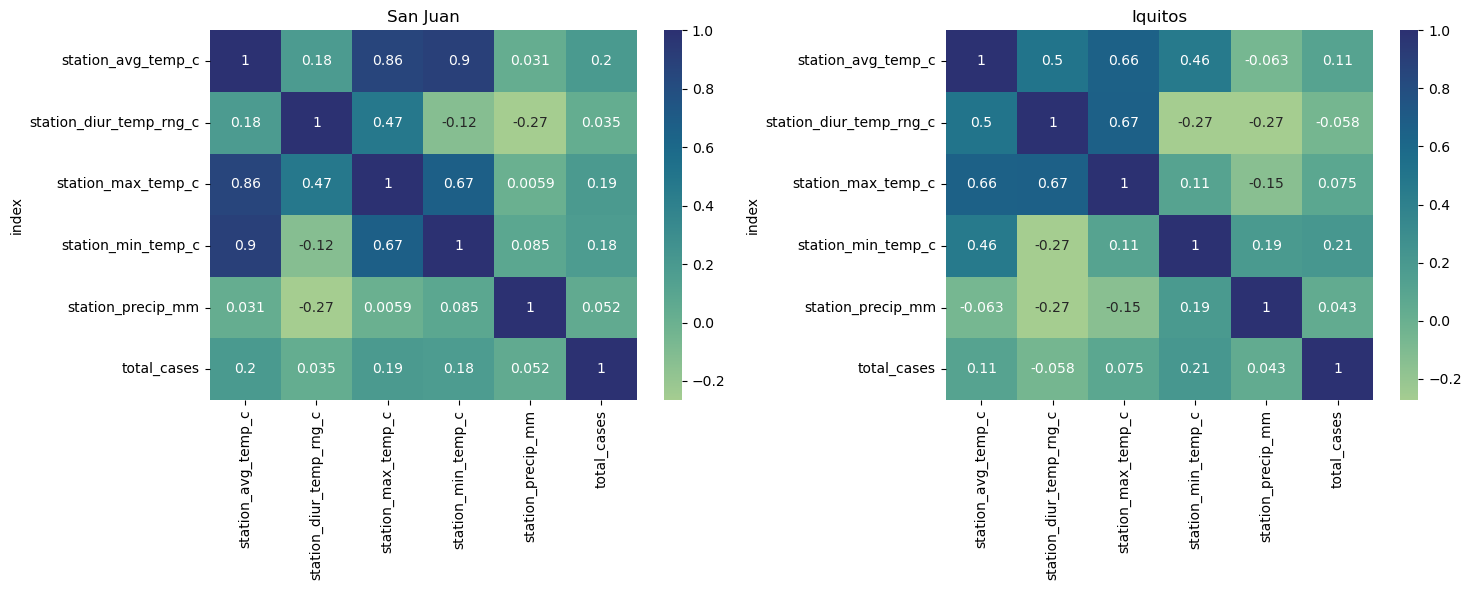

In [24]:
corr_heatmap('station',station,15,6)
matplotlib.rc_file_defaults()

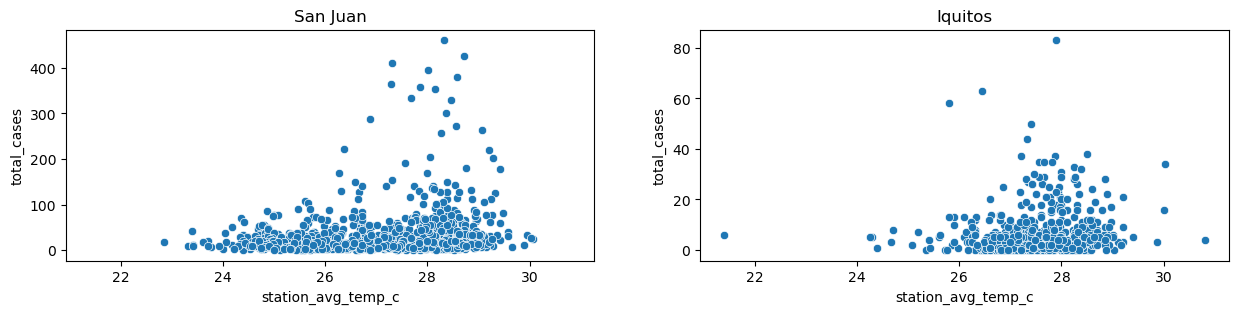

In [25]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

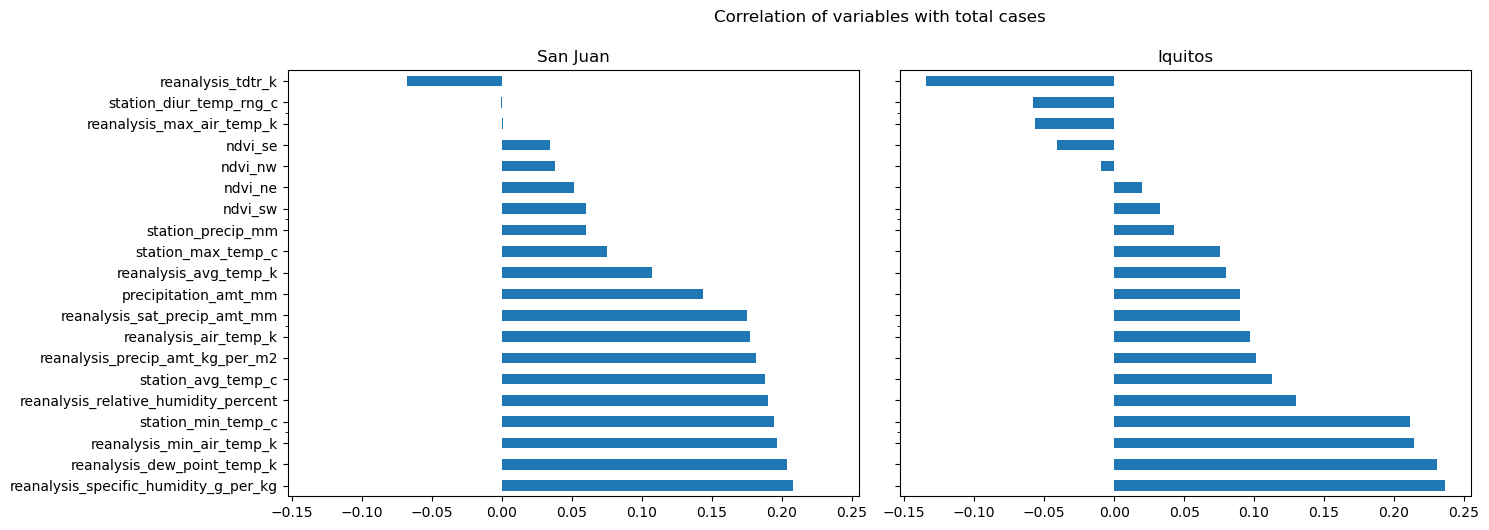

In [26]:
# reference: https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb
fig, axs = plt.subplots(1,2, figsize=(15,5),sharey=True,sharex=True)
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(ax=axs[0]))
axs[0].title.set_text('San Juan');
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(ax=axs[1]))
axs[1].title.set_text('Iquitos');
fig.tight_layout();
fig.suptitle('Correlation of variables with total cases',x=0.59,y=1.05);